In [2]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import plotly.express as px
from collections import defaultdict
from xgboost import XGBClassifier
from IPython.display import display
from sklearn.linear_model import LogisticRegression

## Data Cleaning

## 500K dataset cleaning (with riley's code)

In [3]:
# def clean_party_create_infer():
#     corrected_data  = pd.read_csv("/Users/nirugidla/Documents/GitHub/milestone2_MADS/data_500k.csv", low_memory=False).sample(20000)
#     #Replace blanks and spaces with NaN
#     corrected_data.replace(r'^\s*$', np.nan, regex=True, inplace=True)
#     # Update the 'I' values in PARTY_CODE to 'N' for rows where STATE is 'SD'
#     corrected_data.loc[(corrected_data['STATE'] == 'SD') & (corrected_data['PARTY_CODE'] == 'I'), 'PARTY_CODE'] = 'N'
#     # Update the 'U' values in PARTY_CODE to 'N' for rows where STATE is in ['DC', 'LA', 'RI']
#     states_to_update = ['DC', 'LA', 'RI']
#     corrected_data.loc[(corrected_data['STATE'].isin(states_to_update)) & (corrected_data['PARTY_CODE'] == 'U'), 'PARTY_CODE'] = 'N'
# 
#     # Update the 'I' values in PARTY_CODE to 'N' for rows where STATE is 'OK'
#     corrected_data.loc[(corrected_data['STATE'] == 'OK') & (corrected_data['PARTY_CODE'] == 'I'), 'PARTY_CODE'] = 'N'
#     
#     # print("N's after corrections")
#     # print(len(corrected_data.loc[corrected_data['PARTY_CODE'].isin(['N'])]))
#     # 
#     # print("U's after corrections")
#     # print(len(corrected_data.loc[corrected_data['PARTY_CODE'].isin(['U'])]))
#     # 
#     # print("inferred Rs:")
#     # print(len(corrected_data.loc[corrected_data['PARTY_CODE'].isin(['S'])]))
#     # 
#     # print("inferred Ds:")
#     # print(len(corrected_data.loc[corrected_data['PARTY_CODE'].isin(['E'])]))
#     # 
#     # print("new inferred Rs:")
#     # print(len(corrected_data.loc[corrected_data['PARTY_CODE'].isin(['S'])]))
#     # 
#     # print("new inferred Ds:")
#     # print(len(corrected_data.loc[corrected_data['PARTY_CODE'].isin(['E'])]))
#           
#     # Create party_mapping using defaultdict.Lambda sets default (all other non-D and non-R party registrations to NaN.
#     infer_party_mapping = defaultdict(lambda: float('nan'))
#     infer_party_mapping.update({
#         'D': 'D',  # Registered Democrats are mapped to Democrat
#         'E': 'D',  # E (Inferred Democrats) are mapped to Democrat
#         'R': 'R',  # Registered Republicans are mapped to Republican 
#         'S': 'R',
#         'L' :'R' # S (Inferred Republicans) are mapped to Republican
#     })
#     # Map PARTY_CODE to INFER_PARTY
#     corrected_data['INFER_PARTY'] = corrected_data['PARTY_CODE'].map(infer_party_mapping)
# 
#     # Define the mapping for PARTY_CODE modifications
#     party_code_mapping = {
#         'E': float('nan'),
#         'S': float('nan'),
#         'U': float('nan'),
#         'A': 'O',
#         'B': 'O',
#         'C': 'O',
#         'F': 'O',
#         'G': 'O',
#         'H': 'O',
#         'I': 'O',
#         'J': 'O',
#         'K': 'O',
#       #  'L': 'L',
#         'P': 'O',
#         'Q': 'O',
#         'T': 'O',
#         'V': 'O',
#         'W': 'O',
#         'Y': 'O',
#         'Z': 'O'
#     }
#     # Apply the mapping to the PARTY_CODE column
#     corrected_data['PARTY_CODE'] = corrected_data['PARTY_CODE'].replace(party_code_mapping)
# 
#     # print("Final PARTY_CODE values:")
#     # print(corrected_data['PARTY_CODE'].unique())
#     # print('Final INFER_PARTY values:')
#     # print(corrected_data['INFER_PARTY'].unique())
#     # print('INFER_PARTY Ds and Rs:')
#     # print(len(corrected_data.loc[corrected_data['INFER_PARTY'].isin(['D', 'R'])]))
#     # print('INFER_PARTY NaNs:')
#     # print(corrected_data['INFER_PARTY'].isna().sum())
#     
#     voter_columns = [col for col in corrected_data.columns if col.startswith("VTR")]
#     #Sum Democrat and Republican totals
#     corrected_data['VTR_TOTAL_DVOTES'] = corrected_data[voter_columns].isin(['D', 'M', 'Z']).sum(axis=1)
#     corrected_data['VTR_TOTAL_RVOTES'] = corrected_data[voter_columns].isin(['R', 'P', 'X']).sum(axis=1)
# 
#     #Create conditions that evaluate whether someone has cast at least two more votes for Democrats or Republicans: 
#     conditions = [
#         corrected_data['VTR_TOTAL_DVOTES'] - corrected_data['VTR_TOTAL_RVOTES'] >= 2,
#         corrected_data['VTR_TOTAL_RVOTES'] - corrected_data['VTR_TOTAL_DVOTES'] >= 2
#     ]
#     choices = ['D', 'R']
# 
#     corrected_data['VTR_INFER_PARTY'] = np.select(conditions, choices, default=np.nan)
#     corrected_data['VTR_INFER_PARTY'].replace('nan', np.nan, inplace=True)
# 
#     # Assign a 'D' or an 'R' to INFER_PARTY if either condition is true:
#     corrected_data.loc[(corrected_data['VTR_INFER_PARTY'] == 'D') , 'INFER_PARTY'] = 'D'
#     corrected_data.loc[(corrected_data['VTR_INFER_PARTY'] == 'R') , 'INFER_PARTY'] = 'R'
#         
#     # If anyone has voted Dem or Repub in a more recent election, change their INFER_PARTY label to that party
#     columns_to_check = ['VTR_PPP16', 'VTR_GEN16', 'VTR_GEN18', 'VTR_PRI20', 'VTR_PPP20', 'VTR_GEN20', 'VTR_PRI22', 'VTR_GEN22']
#     democrat_values = ['D', 'M', 'Z']
#     republican_values = ['R', 'P', 'X']
# 
#     # Loop through the columns and set the 'INFER_PARTY' value based on the mappings
#     for column in columns_to_check:
#         corrected_data.loc[corrected_data[column].isin(democrat_values), 'INFER_PARTY'] = 'D'
#         corrected_data.loc[corrected_data[column].isin(republican_values), 'INFER_PARTY'] = 'R'
#     
#     corrected_data.drop(columns=["VTR_INFER_PARTY", "VTR_TOTAL_DVOTES", "VTR_TOTAL_RVOTES"], inplace=True)
#        
#     # print('Final INFER_PARTY Ds and Rs:')
#     # print(len(corrected_data.loc[corrected_data['INFER_PARTY'].isin(['D', 'R'])]))
#     # print('Final INFER_PARTY NaNs:')
#     # print(corrected_data['INFER_PARTY'].isna().sum())
#     
#     return corrected_data
# engineered_data = clean_party_create_infer()
# print(engineered_data.shape)

In [4]:
def clean_party_create_infer():
    #corrected_data  = pd.read_csv("/Users/nirugidla/Documents/GitHub/milestone2_MADS/data_500k.csv", low_memory=False).sample(499999)
    corrected_data  = pd.read_csv("/Users/nirugidla/Documents/GitHub/milestone2_MADS/surveydata.csv", low_memory=False).sample(1000)
    
    corrected_data.replace(r'^\s*$', np.nan, regex=True, inplace=True)

    corrected_data.loc[(corrected_data['STATE'] == 'SD') & (corrected_data['PARTY_CODE'] == 'I'), 'PARTY_CODE'] = 'N'
    states_to_update = ['DC', 'LA', 'RI']
    corrected_data.loc[(corrected_data['STATE'].isin(states_to_update)) & (corrected_data['PARTY_CODE'] == 'U'), 'PARTY_CODE'] = 'N'
    corrected_data.loc[(corrected_data['STATE'] == 'OK') & (corrected_data['PARTY_CODE'] == 'I'), 'PARTY_CODE'] = 'N'

    infer_party_mapping = defaultdict(lambda: float('nan'))
    infer_party_mapping.update({'D': 'D', 'E': 'D', 'R': 'R', 'S': 'R', 'L': 'R'})

    new_columns_df = pd.DataFrame()
    new_columns_df['INFER_PARTY'] = corrected_data['PARTY_CODE'].map(infer_party_mapping)
    
    party_code_mapping = {
        'E': float('nan'),
        'S': float('nan'),
        'U': float('nan'),
        'A': 'O',
        'B': 'O',
        'C': 'O',
        'F': 'O',
        'G': 'O',
        'H': 'O',
        'I': 'O',
        'J': 'O',
        'K': 'O',
        'P': 'O',
        'Q': 'O',
        'T': 'O',
        'V': 'O',
        'W': 'O',
        'Y': 'O',
        'Z': 'O'
    }
    
    corrected_data['PARTY_CODE'] = corrected_data['PARTY_CODE'].replace(party_code_mapping)
    
    voter_columns = [col for col in corrected_data.columns if col.startswith("VTR")]

    new_columns_df['VTR_TOTAL_DVOTES'] = corrected_data[voter_columns].isin(['D', 'M', 'Z']).sum(axis=1)
    new_columns_df['VTR_TOTAL_RVOTES'] = corrected_data[voter_columns].isin(['R', 'P', 'X']).sum(axis=1)

    conditions = [
        new_columns_df['VTR_TOTAL_DVOTES'] - new_columns_df['VTR_TOTAL_RVOTES'] >= 2,
        new_columns_df['VTR_TOTAL_RVOTES'] - new_columns_df['VTR_TOTAL_DVOTES'] >= 2
    ]
    choices = ['D', 'R']

    new_columns_df['VTR_INFER_PARTY'] = np.select(conditions, choices, default=np.nan)

    corrected_data = pd.concat([corrected_data, new_columns_df], axis=1)
    
    corrected_data.loc[(corrected_data['VTR_INFER_PARTY'] == 'D') , 'INFER_PARTY'] = 'D'
    corrected_data.loc[(corrected_data['VTR_INFER_PARTY'] == 'R') , 'INFER_PARTY'] = 'R'

    columns_to_check = ['VTR_PPP16', 'VTR_GEN16', 'VTR_GEN18', 'VTR_PRI20', 'VTR_PPP20', 'VTR_GEN20', 'VTR_PRI22', 'VTR_GEN22']
    democrat_values = ['D', 'M', 'Z']
    republican_values = ['R', 'P', 'X']

    for column in columns_to_check:
        corrected_data.loc[corrected_data[column].isin(democrat_values), 'INFER_PARTY'] = 'D'
        corrected_data.loc[corrected_data[column].isin(republican_values), 'INFER_PARTY'] = 'R'
    
    corrected_data.drop(columns=["VTR_INFER_PARTY", "VTR_TOTAL_DVOTES", "VTR_TOTAL_RVOTES"], inplace=True)
    
    return corrected_data

engineered_data = clean_party_create_infer()
print(engineered_data.shape)

(1000, 305)


In [5]:
def additional_cleaning(data):
    
    # Calculate the percentage of missing data for each column
    missing_data_percentage = data.isnull().mean() * 100

    # Identify columns with more than 90% missing data
    cols_to_remove = missing_data_percentage[missing_data_percentage > 90].index.tolist()
    print(cols_to_remove)
   
    # Drop the identified columns
    data = data.drop(columns=cols_to_remove)

    def convert_with_leading_zero(value):
        if isinstance(value, int) and 0 <= value < 10:
            return '0' + str(value)
        else:
            return str(value)

    data['CONG_DIST'] = data['CONG_DIST'].apply(convert_with_leading_zero)
        
    data['CNS_MEDINC'] = data['CNS_MEDINC'].astype('Int64')
    data['YEARBUILT'] = data['YEARBUILT'].astype('Int64')
    data['VOTER_CNT'] = data['VOTER_CNT'].str.strip().astype('Int64')
    data['VOTER_TRLR'] = data['VOTER_TRLR'].astype(str)
    
    return data
engineered_data = additional_cleaning(engineered_data)
print(engineered_data.shape)

['AFAMPROFLS', 'APP_CHILD', 'APP_MENBIG', 'APP_TODDLR', 'APP_WOMEN', 'APP_WOMPET', 'APP_WOMPLS', 'APP_YNGMEN', 'ASSMLCODE', 'BOATING', 'BUS_OWNER', 'CH_0002FEM', 'CH_0002MAL', 'CH_0002UNK', 'CH_0305FEM', 'CH_0305MAL', 'CH_0305UNK', 'CH_0610FEM', 'CH_0610MAL', 'CH_0610UNK', 'CH_1115FEM', 'CH_1115MAL', 'CH_1115UNK', 'CH_1617FEM', 'CH_1617MAL', 'CH_1617UNK', 'CHRISTFAM', 'COL_ARTS', 'COL_COIN', 'COL_SPORT', 'COL_STAMP', 'COMPHOMOFC', 'DIYLIV', 'DON_ANML', 'DON_ARTCUL', 'DON_ENVIR', 'DON_ENVWLD', 'DON_INTAID', 'DON_OTHER', 'DON_POLCONS', 'DON_POLLIB', 'DON_VET', 'DONATION', 'EDU_ONLINE', 'EQUESTRIAN', 'ETHNICCONF', 'GAMING', 'HH_VETERAN', 'HH_YOUNGAD', 'HIGHENDAPP', 'HISTMIL', 'HUNTING', 'INV_ACTIVE', 'MAIL_DONOR', 'MOTORCYCLE', 'NASCAR', 'PARENTING', 'POOL', 'PRFL_ACTIVE_MIL', 'PRFL_BLM_SUPPORT', 'PRFL_CLINTON_SUPPORT', 'PRFL_EDUCATION', 'PRFL_EVANGELICAL', 'PRFL_GUN_CONTROL', 'PRFL_HEALTHCARE', 'PRFL_HEALTHCARE_REFORM', 'PRFL_INFLUENCER', 'PRFL_LABOR', 'PRFL_LGBT_SUPPORT', 'PRFL_MARIJUAN

In [6]:
remove_columns = [
    'PRFL_LGBT_SUPPORT',
    'PRFL_LIBERAL_NEWS',
    'PRFL_MARIJUANA_REFORM',
    'PRFL_BIDEN_SUPPORT',
    'PRFL_BORDER_SECURITY',
    'PRFL_CONSERVATIVE_NEWS',
    'PRFL_IMMIGRATION_REFORM',
    'PRFL_OBAMA',
    'PRFL_PERSUADABLE_VOTER',
    'PRFL_POLITICAL_IDEOLOGY',
    'PRFL_SANDERS_SUPPORT',
    'PRFL_TRUMP_SUPPORT',
    'ZIP',
    
    'VTR_GEN00', 'VTR_GEN01', 'VTR_GEN02', 'VTR_GEN03', 'VTR_GEN04', 'VTR_GEN05', 'VTR_GEN06', 'VTR_GEN07', 'VTR_GEN08', 'VTR_GEN09', 'VTR_GEN10', 'VTR_GEN11', 'VTR_GEN12', 'VTR_GEN13', 'VTR_GEN14', 'VTR_GEN15', 'VTR_GEN16', 'VTR_GEN17', 'VTR_GEN18', 'VTR_GEN19', 'VTR_GEN20', 'VTR_GEN21', 'VTR_GEN22', 'VTR_OTH00', 'VTR_OTH01', 'VTR_OTH02', 'VTR_OTH03', 'VTR_OTH04', 'VTR_OTH05', 'VTR_OTH06', 'VTR_OTH07', 'VTR_OTH08', 'VTR_OTH09', 'VTR_OTH10', 'VTR_OTH11', 'VTR_OTH12', 'VTR_OTH13', 'VTR_OTH14', 'VTR_OTH15', 'VTR_OTH16', 'VTR_OTH17', 'VTR_OTH18', 'VTR_OTH19', 'VTR_OTH20', 'VTR_OTH21', 'VTR_OTH22', 'VTR_PPP00', 'VTR_PPP04', 'VTR_PPP08', 'VTR_PPP12', 'VTR_PPP16', 'VTR_PPP20', 'VTR_PRI00', 'VTR_PRI01', 'VTR_PRI02', 'VTR_PRI03', 'VTR_PRI04', 'VTR_PRI05', 'VTR_PRI06', 'VTR_PRI07', 'VTR_PRI08', 'VTR_PRI09', 'VTR_PRI10', 'VTR_PRI11', 'VTR_PRI12', 'VTR_PRI13', 'VTR_PRI14', 'VTR_PRI15', 'VTR_PRI16', 'VTR_PRI17', 'VTR_PRI18', 'VTR_PRI19', 'VTR_PRI20', 'VTR_PRI21', 'VTR_PRI22',
    
      'PRFL_CHOICELIFE', "PRFL_GUN_CONTROL",'PRFL_MARRIAGE_EQUALITY', 'PRFL_TEAPARTY',
    'VP_PPP', "AI_COUNTY_NAME", 'PRFL_CLINTON_SUPPORT',
     'CNSUS_PCTW', 'PARTY_MIX', 'PRFL_MINWAGE', 'PRFL_FENCE_SITTER', "RECORD_ID", 'CNSUS_PCTA',
    'PRFL_BLM_SUPPORT', 'PRFL_METOO_SUPPORT', 'PRFL_HEALTHCARE_REFORM','DON_POLLIB', 'PRFL_2NDAMEND', 'FUND_POLIT', 'DON_POLCONS', 
    
   'PARTY_CODE','ST_LO_HOUS', 'ST_UP_HOUS', 'CENSUS_ST', 'COUNTY_ST',
    #'AGE'
]
# Drop the list of columns from the dataset
engineered_data.drop(columns=remove_columns, errors='ignore', inplace=True)
print(engineered_data.shape)

(1000, 115)


In [7]:
print(engineered_data.columns)

Index(['ADD_TYPE', 'AGE', 'AIRCOND', 'ARTS', 'AUTOACCES', 'AUTOWORK',
       'BROADERLIV', 'CARDUSER', 'CATOWNER', 'CENSUS_TRK',
       ...
       'VP_PRI', 'WORKWOMAN', 'YEARBUILT', 'Q1_Candidate', 'Q2_Support',
       'Q3_Party', 'Q4_LikelyVoter', 'Q5_TrumpSupport', 'SURVEY_TYPE',
       'INFER_PARTY'],
      dtype='object', length=115)


In [8]:
engineered_data.sample(10)

,ADD_TYPE,AGE,AIRCOND,ARTS,AUTOACCES,AUTOWORK,BROADERLIV,CARDUSER,CATOWNER,CENSUS_TRK,...,VP_PRI,WORKWOMAN,YEARBUILT,Q1_Candidate,Q2_Support,Q3_Party,Q4_LikelyVoter,Q5_TrumpSupport,SURVEY_TYPE,INFER_PARTY
1026,S,82.0,G,NaN,NaN,Y,Y,Y,Y,21612.0,...,60.0,Y,1972,Senator Tim Scott,Somewhat Likely to Support,Republican,Extremely Likely,Never Trump,L,R
497,S,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,971501.0,...,0.0,NaN,<NA>,Governor Ron DeSantis,Very likely to support,Republican,Extremely likely,Maybe Trump,T,NaN
888,H,88.0,A,NaN,Y,Y,NaN,Y,NaN,941002.0,...,30.0,NaN,1977,President Joe Biden,Very Likely to Support,Democrat,Extremely Likely,Never Trump,L,D
64,S,30.0,NaN,NaN,NaN,NaN,NaN,Y,NaN,270400.0,...,0.0,NaN,<NA>,President Donald Trump,Very likely to support,Republican,Extremely likely,Forever Trump,T,R
925,S,88.0,NaN,Y,Y,Y,Y,Y,Y,930200.0,...,10.0,NaN,1971,President Joe Biden,NaN,Democrat,Extremely Likely,Never Trump,L,D
911,S,83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,470501.0,...,60.0,NaN,<NA>,President Joe Biden,Very Likely to Support,Democrat,Extremely Likely,Never Trump,L,NaN
1295,H,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,...,100.0,NaN,<NA>,President Joe Biden,Very likely to support,Republican,Extremely likely,Never Trump,T,D
534,S,55.0,NaN,Y,NaN,NaN,NaN,Y,NaN,970100.0,...,0.0,Y,<NA>,President Donald Trump,Very likely to support,Republican,Extremely likely,Forever Trump,T,R
1224,S,60.0,NaN,NaN,Y,Y,NaN,Y,NaN,10201.0,...,0.0,NaN,1993,President Donald Trump,Likely to Support,Unaffiliated/Other,Very Likely,Maybe Trump,L,R
1348,S,67.0,NaN,Y,Y,Y,NaN,Y,NaN,451103.0,...,30.0,Y,1991,President Donald Trump,Very likely to support,Republican,Extremely likely,Forever Trump,T,R


In [9]:
# # Assuming your DataFrame is named 'engineered_data'
# 
# # Get summary statistics of numerical columns
# print("\nSummary statistics of numerical columns:")
# print(engineered_data.describe())
# 
# # Get data types of each column
# print("\nData types of each column:")
# print(engineered_data.dtypes)

# Identify columns that are numerical and categorical
numerical_cols = engineered_data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = engineered_data.select_dtypes(include=['object']).columns

print("\nNumerical Columns:")
print(numerical_cols)
print(len(numerical_cols))
# print("\nCategorical Columns:")
# print(categorical_cols)


Numerical Columns:
Index(['AGE', 'CENSUS_TRK', 'CNS_MEDINC', 'CNSUS_PCTB', 'CNSUS_PCTH',
       'CNSUS_PCTI', 'CNSUS_PCTM', 'CNSUS_PCTO', 'CNSUS_PCTP',
       'TOD_PRES_D_2016', 'TOD_PRES_D_2016_PREC', 'TOD_PRES_D_2020_PREC',
       'TOD_PRES_O_2016', 'TOD_PRES_O_2016_PREC', 'TOD_PRES_O_2020_PREC',
       'TOD_PRES_R_2016', 'TOD_PRES_R_2016_PREC', 'TOD_PRES_R_2020_PREC',
       'TRAIL_CNT', 'VOTER_CNT', 'VP_GEN', 'VP_OTH', 'VP_PRI', 'YEARBUILT'],
      dtype='object')
24


In [10]:
# Check for unique values in categorical columns
print("\nUnique values in categorical columns:")
for col in categorical_cols:
    print(f"{col}: {engineered_data[col].unique()}")


Unique values in categorical columns:
ADD_TYPE: ['S' 'H' nan]
AIRCOND: [nan 'G' 'A' 'F' 'I' 'E' 'H' 'C' 'J' 'B' 'K' 'D']
ARTS: ['Y' nan]
AUTOACCES: [nan 'Y']
AUTOWORK: [nan 'Y']
BROADERLIV: ['Y' nan]
CARDUSER: ['Y' nan]
CATOWNER: [nan 'Y']
COL_ANTIQ: [nan 'Y']
COMPUTERS: [nan 'Y']
CONG_DIST: ['07' '02' '06' '12' '11' '01' '09' '03' '05' '15' '9 ' '08' '47' '18'
 '10' '13' '31' '14' '36' '26' '20' '17' '22' '04' '21' '24' '1 ' '19'
 '40' '28' '25' '23' '44' '16' '2 ' '4 ' '37' '33' '48' '4' '6 ' '38' '32'
 '9' '3 ' '8 ' '5 ' '41' '30' 'nan' '7 ' '49' '52' '29' '2' '42' '35']
COOK_GEN: [nan 'Y']
COUNTY_TYPE: ['U' 'R' nan]
CRD_RANGE: [nan '1' '3' '6' '5' '4' '7' '2' '0']
CREDRATE: ['C' 'D' 'B' 'F' 'H' nan 'A' 'E' 'G']
CURRAFFAIR: [nan 'Y']
DEPTSTCRD: ['Y' nan]
DIETING: ['Y' nan]
DOGOWNER: ['Y' nan]
DON_CHARIT: ['Y' nan]
DON_CHILD: [nan 'Y']
DON_HEALTH: ['Y' nan]
DON_POLIT: ['Y' nan]
DON_RELIG: ['Y' nan]
EDUCATION: [nan 'B' 'C' 'D' 'A']
ETHNIC_INFER: [nan 'H' 'C' 'B' 'A']
ETHNICCODE: [nan

In [11]:
def preprocess_dataframe(df):
    # Initial count of numerical and non-numerical columns
    initial_numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    initial_non_numerical_cols = df.select_dtypes(include=['object']).columns

    print(f"Initial Numerical Columns Count: {len(initial_numerical_cols)}")
    print(f"Initial Non-Numerical Columns Count: {len(initial_non_numerical_cols)}")

    # Create a copy of the DataFrame to avoid modifying the original one
    converted_data = df.copy()

    # Initialize counters for numerical and non-numerical columns
    num_cols_count = 0
    non_num_cols_count = 0

    # Loop through each column and try to convert it to numerical data types
    for col in converted_data.columns:
        try:
            # Try converting to 'int64'
            converted_data[col] = converted_data[col].astype('int64')
            num_cols_count += 1
        except ValueError:
            try:
                # If that fails, try converting to 'float64'
                converted_data[col] = converted_data[col].astype('float64')
                num_cols_count += 1
            except ValueError:
                # If both fail, the column is genuinely non-numeric
                non_num_cols_count += 1
                print(f"Column {col} couldn't be converted to 'int64' or 'float64'. It is non-numeric.")

    # Display the data types after the conversion
    print("\nData types after conversion:")
    print(converted_data.dtypes)

    # Display count of numerical and non-numerical columns
    print(f"\nTotal Numerical Columns after conversion: {num_cols_count}")
    print(f"Total Non-Numerical Columns after conversion: {non_num_cols_count}")

    return converted_data

# Assuming your DataFrame is named 'engineered_data'
processed_data = preprocess_dataframe(engineered_data)
print(processed_data.shape)

Initial Numerical Columns Count: 24
Initial Non-Numerical Columns Count: 91
Column ADD_TYPE couldn't be converted to 'int64' or 'float64'. It is non-numeric.
Column AIRCOND couldn't be converted to 'int64' or 'float64'. It is non-numeric.
Column ARTS couldn't be converted to 'int64' or 'float64'. It is non-numeric.
Column AUTOACCES couldn't be converted to 'int64' or 'float64'. It is non-numeric.
Column AUTOWORK couldn't be converted to 'int64' or 'float64'. It is non-numeric.
Column BROADERLIV couldn't be converted to 'int64' or 'float64'. It is non-numeric.
Column CARDUSER couldn't be converted to 'int64' or 'float64'. It is non-numeric.
Column CATOWNER couldn't be converted to 'int64' or 'float64'. It is non-numeric.
Column COL_ANTIQ couldn't be converted to 'int64' or 'float64'. It is non-numeric.
Column COMPUTERS couldn't be converted to 'int64' or 'float64'. It is non-numeric.
Column COOK_GEN couldn't be converted to 'int64' or 'float64'. It is non-numeric.
Column COUNTY_TYPE cou

## time decorator

In [12]:
def timer_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Elapsed time: {elapsed_time:.2f} seconds")
        return result
    return wrapper

### Feature Selection with Random Forest Generator

In [13]:
@timer_decorator
def run_random_forest(data, sample_size=500, num_runs=1, top_N_features=10):
    results_list = []

    for run in range(1, num_runs + 1):
        print(f"Starting Random Forest run {run}...")
        
        # Copy the original data to work with
        data_copy = data.copy()
        
        # Drop rows with missing 'INFER_CODE'
        data_copy = data_copy.dropna(subset=['INFER_PARTY'])
        
        # Sample data
        data_sample = data_copy.sample(n=sample_size, random_state=42+run)
        
        # Encode all object type columns
        le = LabelEncoder()
        for col in data_sample.select_dtypes(include=['object']).columns:
            data_sample[col] = le.fit_transform(data_sample[col].astype(str))
        
        # Impute missing values with column means
        imputer = SimpleImputer(strategy='mean')
        data_sample = imputer.fit_transform(data_sample)
        
        # Convert back to DataFrame after imputation
        data_sample = pd.DataFrame(data_sample, columns=data_copy.columns)
        
        # Extract features and target variable
        X = data_sample.drop(columns=['INFER_PARTY'])
        y = data_sample['INFER_PARTY']
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Initialize Random Forest Classifier
        rf = RandomForestClassifier(random_state=42+run)
        
        # Fit the model
        rf.fit(X_train, y_train)
        
        # Make predictions
        y_pred = rf.predict(X_test)
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        
        # Get top N features using feature_importances_
        top_feature_indices = np.argsort(rf.feature_importances_)[::-1][:top_N_features]
        top_features = X.columns[top_feature_indices].tolist()
        
        # Append results to the list
        results_list.append({
            'Run': run,
            'Accuracy': accuracy,
            'F1_Score': f1,
            'Recall': recall,
            'Top_N_Features': top_features
        })

    # Create a DataFrame from the results list
    results_df = pd.DataFrame(results_list)

    return results_df
result = run_random_forest(processed_data, sample_size=500, num_runs=2, top_N_features=10)
result

Starting Random Forest run 1...
Starting Random Forest run 2...
Elapsed time: 0.22 seconds


,Run,Accuracy,F1_Score,Recall,Top_N_Features
0,1,0.77,0.776699,0.740741,"[Q3_Party, Q5_TrumpSupport, Q1_Candidate, TOD_..."
1,2,0.78,0.784314,0.727273,"[Q5_TrumpSupport, Q3_Party, Q1_Candidate, TOD_..."


#### Plot for Random Forest Generator for Feature Selection

Starting Random Forest run for feature importance...


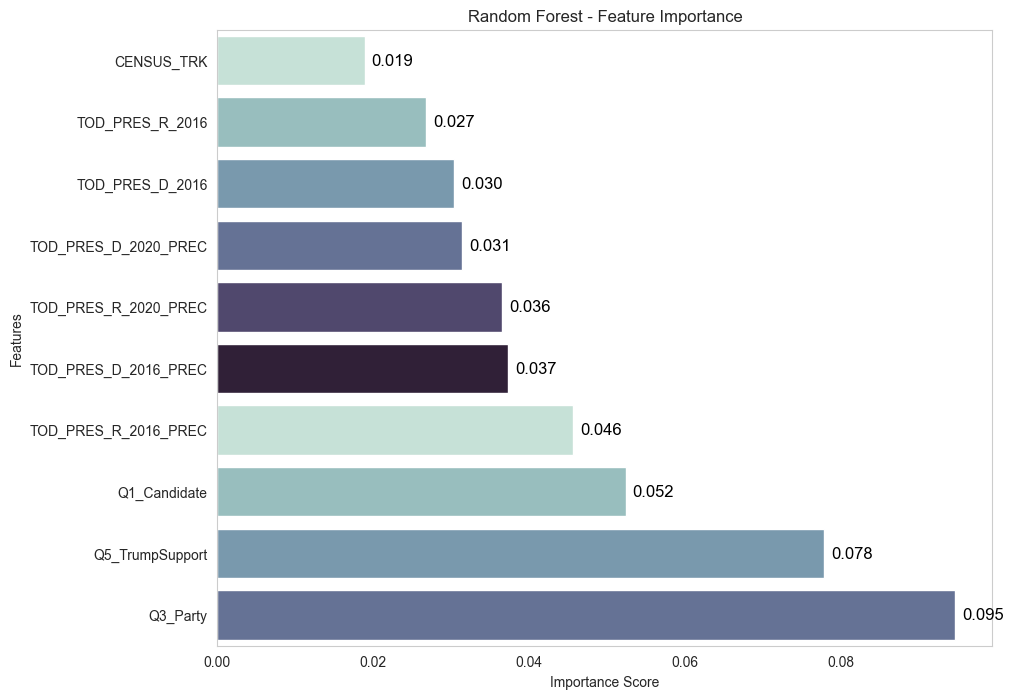

Elapsed time: 0.22 seconds


In [14]:
@timer_decorator
def plot_feature_importance(importance, names, model_type):
    feature_importance = pd.DataFrame({'feature': names, 'importance': importance})
    feature_importance = feature_importance.sort_values(by='importance', ascending=True)
    
    plt.figure(figsize=(10, 8))
    
    cubehelix_palette = sns.cubehelix_palette(start=.5, rot=-.5)
    
    ax = sns.barplot(x="importance", y="feature", data=feature_importance, palette=cubehelix_palette)
    
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.3f}', 
                    (p.get_width(), p.get_y() + p.get_height() / 2.), 
                    ha='left', 
                    va='center', 
                    fontsize=12, 
                    color='black',
                    xytext=(5, 0), 
                    textcoords='offset points')
    
    plt.title(f'{model_type} - Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.grid(False)
    plt.show()
def run_random_forest_for_feature_importance(data, sample_size=500, top_N_features=10):
    print("Starting Random Forest run for feature importance...")

    # Copy the original data to work with
    data_copy = data.copy()

    # Drop rows with missing 'INFER_CODE'
    data_copy = data_copy.dropna(subset=['INFER_PARTY'])

    # Sample data
    data_sample = data_copy.sample(n=sample_size, random_state=42)

    # Encode all object type columns
    le = LabelEncoder()
    for col in data_sample.select_dtypes(include=['object']).columns:
        data_sample[col] = le.fit_transform(data_sample[col].astype(str))

    # Impute missing values with column means
    imputer = SimpleImputer(strategy='mean')
    data_sample = imputer.fit_transform(data_sample)

    # Convert back to DataFrame after imputation
    data_sample = pd.DataFrame(data_sample, columns=data_copy.columns)

    # Extract features and target variable
    X = data_sample.drop(columns=['INFER_PARTY'])
    y = data_sample['INFER_PARTY']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize Random Forest Classifier
    rf = RandomForestClassifier(random_state=42)

    # Fit the model
    rf.fit(X_train, y_train)

    # Get top N features using feature_importances_
    top_feature_indices = np.argsort(rf.feature_importances_)[::-1][:top_N_features]
    top_features = X.columns[top_feature_indices].tolist()

    # Plot feature importance
    plot_feature_importance(rf.feature_importances_[top_feature_indices], top_features, 'Random Forest')

# Assuming processed_data is your DataFrame
run_random_forest_for_feature_importance(processed_data, sample_size=500, top_N_features=10)


In [15]:
result['Top_N_Features'][0]

['Q3_Party',
 'Q5_TrumpSupport',
 'Q1_Candidate',
 'TOD_PRES_D_2016_PREC',
 'TOD_PRES_R_2016_PREC',
 'TOD_PRES_D_2020_PREC',
 'TOD_PRES_D_2016',
 'TOD_PRES_R_2020_PREC',
 'TOD_PRES_R_2016',
 'CENSUS_TRK']

### Feature Selection with Gradient boosting

In [27]:
@timer_decorator
def run_gradient_boosting(data, sample_size=500, num_runs=1, top_N_features=10, pos_label='D'):
    results_list = []
    
    for run in range(1, num_runs + 1):
        print(f"Starting Gradient Boosting run {run}...")
        
        data_copy = data.copy()
        data_copy = data_copy.dropna(subset=['INFER_PARTY'])
        data_sample = data_copy.sample(n=sample_size, random_state=42)
        
        y = data_sample['INFER_PARTY']
        X = data_sample.drop('INFER_PARTY', axis=1)
        
        X = pd.get_dummies(X, drop_first=True)
        
        class_counts = y.value_counts()
        min_class_count = class_counts.min()
        
        imputer = SimpleImputer(strategy='mean')
        X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
        
        if min_class_count > 1:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
        else:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
        
        gb = GradientBoostingClassifier(random_state=42)
        gb.fit(X_train, y_train)
        
        y_pred = gb.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, pos_label=pos_label)
        recall = recall_score(y_test, y_pred, pos_label=pos_label)
        
        k_best = SelectKBest(score_func=chi2, k=top_N_features)
        k_best.fit(X_train, y_train)
        top_feature_indices = np.argsort(k_best.scores_)[::-1][:top_N_features]
        top_features = X.columns[top_feature_indices].tolist()
        
        results_list.append({
            'Run': run,
            'Accuracy': accuracy,
            'F1_Score': f1,
            'Recall': recall,
            'Top_N_Features': top_features
        })

    results_df = pd.DataFrame(results_list)

    return results_df

result = run_gradient_boosting(processed_data, sample_size=500, num_runs=2, top_N_features=10)
#result = run_gradient_boosting(processed_data, sample_size=50000, num_runs=2, top_N_features=10)
result

Starting Gradient Boosting run 1...
Starting Gradient Boosting run 2...
Elapsed time: 0.93 seconds


,Run,Accuracy,F1_Score,Recall,Top_N_Features
0,1,0.8,0.8,0.833333,"[TOD_PRES_DIFF_2016_66R, TOD_PRES_DIFF_2016_PR..."
1,2,0.8,0.8,0.833333,"[TOD_PRES_DIFF_2016_66R, TOD_PRES_DIFF_2016_PR..."


#### Plot for Gradient Boosting for Feature Selection

Starting Gradient Boosting...


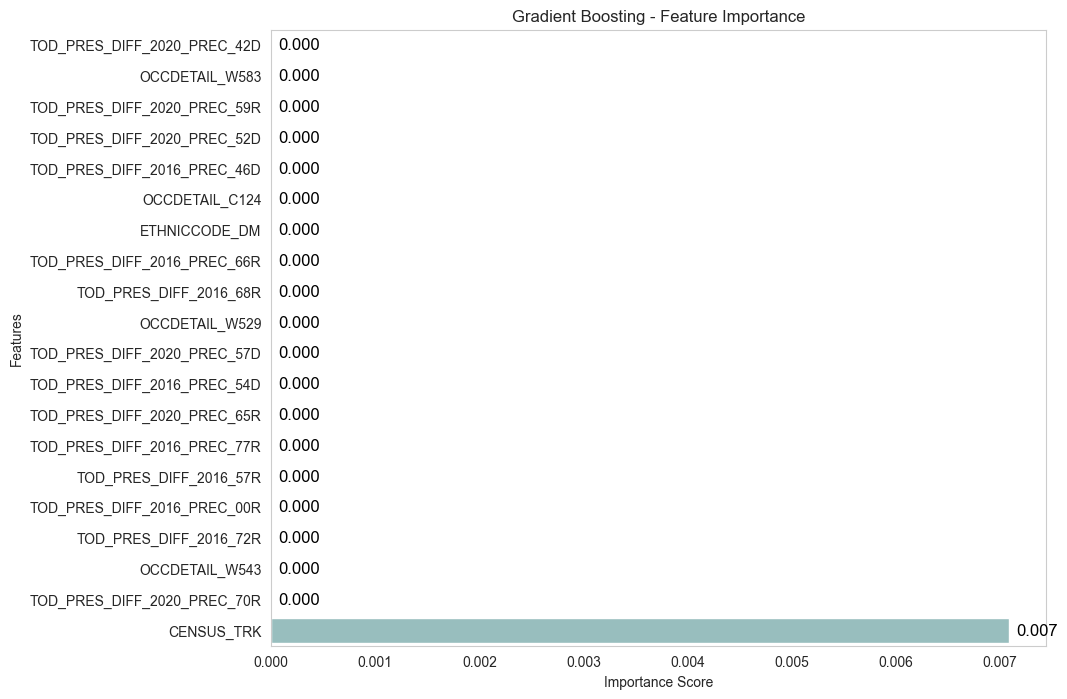

Elapsed time: 0.67 seconds


In [25]:
# bar plot with plotly
@timer_decorator
def run_gradient_boosting_for_feature_importance(data, sample_size=500, top_N_features=10):
    print(f"Starting Gradient Boosting...")
    
    data_copy = data.copy()
    data_copy = data_copy.dropna(subset=['INFER_PARTY'])
    data_sample = data_copy.sample(n=sample_size, random_state=42)
    
    y = data_sample['INFER_PARTY']
    X = data_sample.drop('INFER_PARTY', axis=1)
    
    X = pd.get_dummies(X, drop_first=True)
    
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    gb = GradientBoostingClassifier(random_state=42)
    gb.fit(X_train, y_train)
    
    k_best = SelectKBest(score_func=chi2, k=top_N_features)
    k_best.fit(X_train, y_train)
    top_feature_indices = np.argsort(k_best.scores_)[::-1][:top_N_features]
    top_features = X.columns[top_feature_indices].tolist()
    
    # Plot feature importance
    feature_importances = gb.feature_importances_[top_feature_indices]
    plot_feature_importance(feature_importances, top_features, 'Gradient Boosting')

def plot_feature_importance(importance, names, model_type):
    feature_importance = pd.DataFrame({'feature': names, 'importance': importance})
    feature_importance = feature_importance.sort_values(by='importance', ascending=True)
    
    plt.figure(figsize=(10, 8))
    
    cubehelix_palette = sns.cubehelix_palette(start=.5, rot=-.5)
    
    ax = sns.barplot(x="importance", y="feature", data=feature_importance, palette=cubehelix_palette)
    
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.3f}', 
                    (p.get_width(), p.get_y() + p.get_height() / 2.), 
                    ha='left', 
                    va='center', 
                    fontsize=12, 
                    color='black',
                    xytext=(5, 0), 
                    textcoords='offset points')
    
    plt.title(f'{model_type} - Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.grid(False)
    plt.show()

# Assuming processed_data is your dataset, you can call the function like this:
run_gradient_boosting_for_feature_importance(processed_data, sample_size=500, top_N_features=20)

In [26]:
result['Top_N_Features'][0]

['TOD_PRES_DIFF_2016_66R',
 'TOD_PRES_DIFF_2016_PREC_80D',
 'TOD_PRES_DIFF_2016_18R',
 'TOD_PRES_DIFF_2020_PREC_82D',
 'TOD_PRES_DIFF_2020_PREC_59R',
 'TOD_PRES_DIFF_2020_PREC_88R',
 'ETHNICCODE_DM',
 'TOD_PRES_DIFF_2020_PREC_42D',
 'STATE_NV',
 'ETHNICCODE_RB']

### Feature Selection with Logistic Regression

In [19]:
@timer_decorator
def run_logistic_regression(data, sample_size=500, num_runs=1, top_N_features=10):
    results_list = []

    for run in range(1, num_runs + 1):
        print(f"Starting Logistic Regression run {run}...")
        
        # Copy the original data to work with
        data_copy = data.copy()
        
        # Drop rows with missing 'INFER_PARTY'
        data_copy = data_copy.dropna(subset=['INFER_PARTY'])
        
        # Sample data
        data_sample = data_copy.sample(n=sample_size, random_state=42+run)
        
        # Encode 'INFER_PARTY' column
        le = LabelEncoder()
        data_sample['INFER_PARTY'] = le.fit_transform(data_sample['INFER_PARTY'].astype(str))
        
        # Check for classes with only one instance after sampling and encoding
        class_counts = data_sample['INFER_PARTY'].value_counts()
        min_class_count = class_counts.min()
        
        # Select numerical columns
        numerical_cols = data_sample.select_dtypes(include=['int64', 'float64']).columns
        
        # Drop 'INFER_PARTY' from the numerical columns as it is the target variable
        numerical_cols = numerical_cols.drop('INFER_PARTY')

        # Impute missing values with column means
        imputer = SimpleImputer(strategy='mean')
        data_sample[numerical_cols] = imputer.fit_transform(data_sample[numerical_cols])
        
        # Extract features and target variable
        X = data_sample[numerical_cols]
        y = data_sample['INFER_PARTY']
        
        # Train-test split
        if min_class_count > 1:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
        else:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
        
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Initialize Logistic Regression model
        lr = LogisticRegression(C=0.1, max_iter=10000, random_state=42+run)
    
        # Fit the model
        lr.fit(X_train, y_train)
        
        # Make predictions
        y_pred = lr.predict(X_test)
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, zero_division='warn')
        
        # Get top N features using SelectKBest with chi-squared
        k_best = SelectKBest(score_func=chi2, k=top_N_features)
        k_best.fit(X_train, y_train)
        top_feature_indices = np.argsort(k_best.scores_)[::-1][:top_N_features]
        top_features = X.columns[top_feature_indices].tolist()
        
        # Append results to the list
        results_list.append({
            'Run': run,
            'Accuracy': accuracy,
            'F1_Score': f1,
            'Recall': recall,
            'Top_N_Features': top_features
        })

    # Create a DataFrame from the results list
    results_df = pd.DataFrame(results_list)

    return results_df

# Assuming data_500 is your dataset, you can call the function like this:
result = run_logistic_regression(processed_data, sample_size=500, num_runs=10, top_N_features=30)
result

Starting Logistic Regression run 1...
Starting Logistic Regression run 2...
Starting Logistic Regression run 3...
Starting Logistic Regression run 4...
Starting Logistic Regression run 5...
Starting Logistic Regression run 6...
Starting Logistic Regression run 7...
Starting Logistic Regression run 8...
Starting Logistic Regression run 9...
Starting Logistic Regression run 10...
Elapsed time: 0.41 seconds


,Run,Accuracy,F1_Score,Recall,Top_N_Features
0,1,0.56,0.620690,0.692308,"[CNSUS_PCTB, TOD_PRES_D_2016_PREC, TOD_PRES_R_..."
1,2,0.64,0.666667,0.666667,"[CNSUS_PCTB, TOD_PRES_D_2016_PREC, TOD_PRES_R_..."
2,3,0.66,0.679245,0.692308,"[CNSUS_PCTB, TOD_PRES_D_2016_PREC, TOD_PRES_R_..."
3,4,0.62,0.641509,0.680000,"[CNSUS_PCTB, TOD_PRES_D_2016_PREC, TOD_PRES_R_..."
4,5,0.78,0.807018,0.884615,"[CNSUS_PCTB, TOD_PRES_D_2016_PREC, TOD_PRES_R_..."
5,6,0.70,0.716981,0.760000,"[TOD_PRES_D_2016_PREC, TOD_PRES_D_2016, TOD_PR..."
6,7,0.68,0.724138,0.777778,"[TOD_PRES_D_2016_PREC, CNSUS_PCTB, TOD_PRES_R_..."
7,8,0.68,0.703704,0.730769,"[TOD_PRES_D_2016_PREC, CNSUS_PCTB, TOD_PRES_R_..."
8,9,0.62,0.666667,0.703704,"[CNSUS_PCTB, TOD_PRES_D_2016_PREC, TOD_PRES_R_..."
9,10,0.68,0.714286,0.740741,"[TOD_PRES_D_2016_PREC, CNSUS_PCTB, TOD_PRES_D_..."


#### Plot for Logistic Regression for Feature Selection

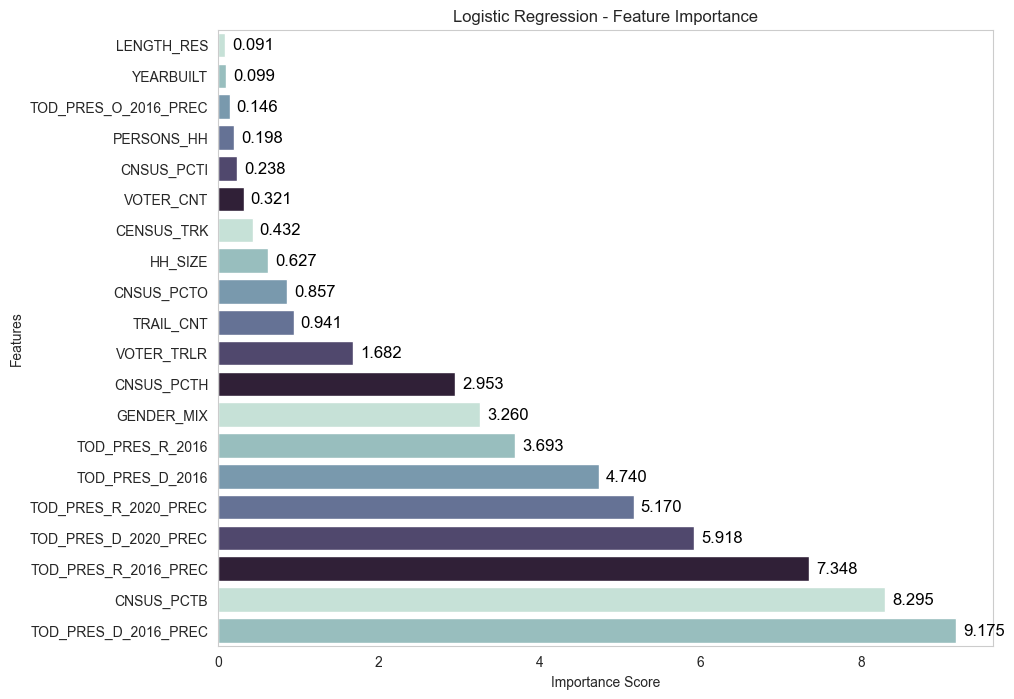

Elapsed time: 0.33 seconds


In [20]:
@timer_decorator
def plot_feature_importance(importance, names, model_type):
    feature_importance = pd.DataFrame({'feature': names, 'importance': importance})
    feature_importance = feature_importance.sort_values(by='importance', ascending=True)
    
    plt.figure(figsize=(10, 8))
    
    cubehelix_palette = sns.cubehelix_palette(start=.5, rot=-.5)
    
    ax = sns.barplot(x="importance", y="feature", data=feature_importance, palette=cubehelix_palette)
    
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.3f}', 
                    (p.get_width(), p.get_y() + p.get_height() / 2.), 
                    ha='left', 
                    va='center', 
                    fontsize=12, 
                    color='black',
                    xytext=(5, 0), 
                    textcoords='offset points')
    
    plt.title(f'{model_type} - Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.grid(False)
    plt.show()


def run_logistic_regression_for_feature_importance(data, sample_size=500, top_N_features=10):
    # Copy the original data to work with
    data_copy = data.copy()
    
    # Drop rows with missing 'INFER_PARTY'
    data_copy = data_copy.dropna(subset=['INFER_PARTY'])
    
    # Sample data
    data_sample = data_copy.sample(n=sample_size, random_state=42)
    
    # Encode 'INFER_PARTY' column
    le = LabelEncoder()
    data_sample['INFER_PARTY'] = le.fit_transform(data_sample['INFER_PARTY'].astype(str))
    
    # Select numerical columns
    numerical_cols = data_sample.select_dtypes(include=['int64', 'float64']).columns
    
    # Drop 'INFER_PARTY' from the numerical columns as it is the target variable
    numerical_cols = numerical_cols.drop('INFER_PARTY')

    # Impute missing values with column means
    imputer = SimpleImputer(strategy='mean')
    data_sample[numerical_cols] = imputer.fit_transform(data_sample[numerical_cols])
    
    # Extract features and target variable
    X = data_sample[numerical_cols]
    y = data_sample['INFER_PARTY']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Initialize Logistic Regression model
    lr = LogisticRegression(C=0.1, max_iter=10000, random_state=42)
    
    # Fit the model
    lr.fit(X_train, y_train)
    
    # Get top N features using SelectKBest with chi-squared
    k_best = SelectKBest(score_func=chi2, k=top_N_features)
    k_best.fit(X_train, y_train)
    top_feature_indices = np.argsort(k_best.scores_)[::-1][:top_N_features]
    top_features = X.columns[top_feature_indices].tolist()
    
    # Plot feature importance
    feature_importances = k_best.scores_[top_feature_indices]
    plot_feature_importance(feature_importances, top_features, 'Logistic Regression')

# Assuming processed_data is your dataset, you can call the function like this:
run_logistic_regression_for_feature_importance(processed_data, sample_size=500, top_N_features=20)


#### Modeling XGradientBoosting

Starting run 1...
Number of columns in the dataset: 115
Run 1 - Baseline Metrics: Accuracy: 0.81, F1 Score: 0.819047619047619, Recall: 0.8269230769230769
['Q1_Candidate', 'TOD_PRES_DIFF_2020_PREC', 'ARTS', 'LIFESTAGE_CLUSTER', 'CURRAFFAIR', 'AUTOACCES', 'AIRCOND', 'HITECHLIV', 'STATE', 'EXER_GROUP', 'TOD_PRES_DIFF_2016', 'TOD_PRES_D_2016_PREC', 'HOMEOWNRNT', 'Q3_Party', 'STATUS', 'HH_SENIOR', 'HOMEMKTVAL', 'HIGHBROW', 'CONG_DIST', 'TOD_PRES_R_2020_PREC', 'TOD_PRES_D_2020_PREC', 'VP_GEN', 'CNSUS_PCTO', 'ETHNICGRP', 'INCOMESTHH', 'OCCUPATION', 'CREDRATE', 'TOD_PRES_R_2016_PREC', 'HOMEOWNER', 'NETWORTH', 'CENSUS_TRK', 'TOD_PRES_DIFF_2016_PREC', 'GENDER_MIX', 'AGE', 'COUNTY_TYPE', 'PETS', 'TOD_PRES_D_2016', 'LENGTH_RES', 'EDUCATION', 'CNS_MEDINC', 'CRD_RANGE', 'Q4_LikelyVoter', 'GARDENER', 'RD_GEN', 'ETHNICCODE', 'PERSONS_HH', 'VP_OTH', 'YEARBUILT', 'TOD_PRES_O_2020_PREC', 'ETHNIC_INFER']


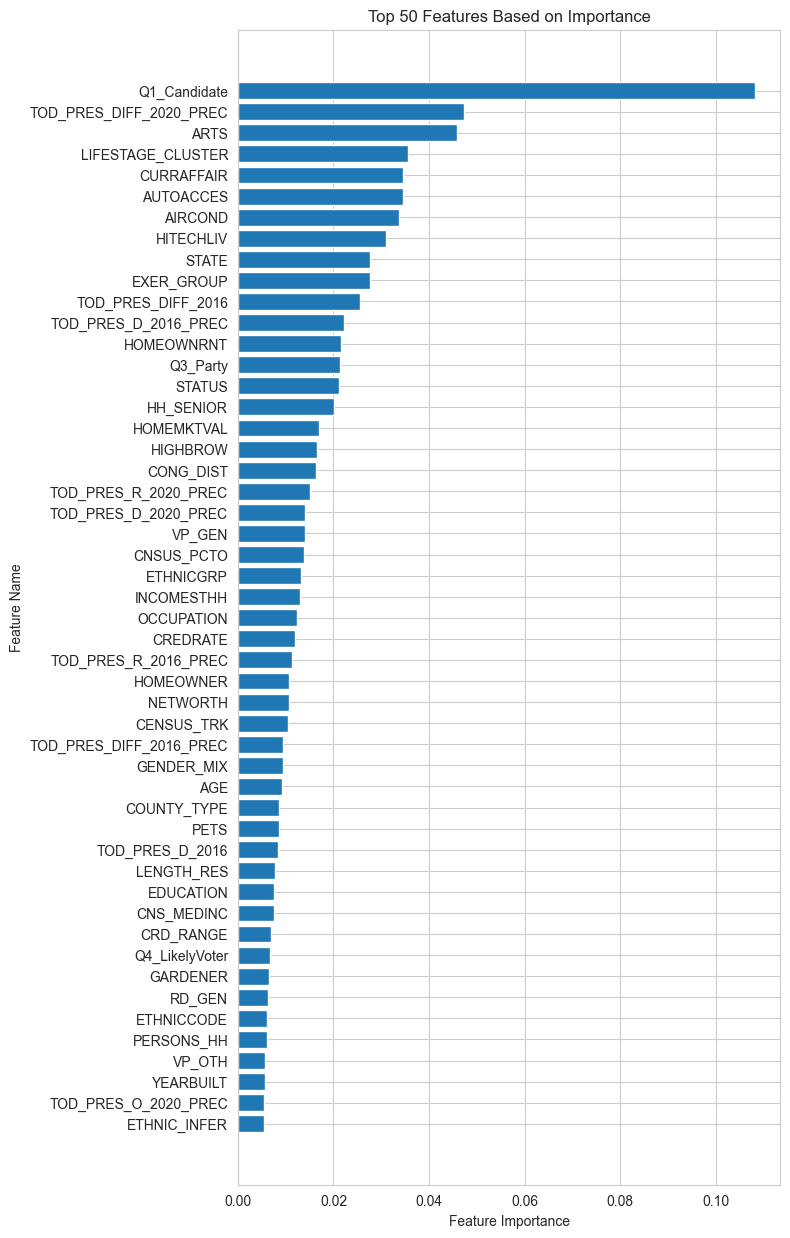

Run 1 - Model performance with top 50 features:
Accuracy: 0.74
F1 Score: 0.7678571428571429
Recall: 0.8269230769230769
Elapsed time: 0.59 seconds


,Run,Accuracy,Recall,F1_Score,Accuracy_Top_50,F1_Score_Top_50,Top_N_Features
0,1,0.81,0.826923,0.819048,0.74,0.767857,"[Q1_Candidate, TOD_PRES_DIFF_2020_PREC, ARTS, ..."


In [21]:
@timer_decorator
def run_xgboost_all_columns(data, sample_size=500, num_runs=1, top_N_features=50):
    results_list = []
    le = LabelEncoder()  # Initialize the label encoder

    for run in range(1, num_runs + 1):
        print(f"Starting run {run}...")
        
        data_with_all_columns = data.copy()
        data_with_all_columns = data_with_all_columns[data_with_all_columns['INFER_PARTY'].notna()]
        
        print("Number of columns in the dataset:", len(data_with_all_columns.columns))

        data_sample = data_with_all_columns.sample(n=sample_size, random_state=42)

        # Convert object columns to category type
        for col in data_sample.select_dtypes(['object']).columns:
            data_sample[col] = data_sample[col].astype('category')

        # Splitting the data into features and target without encoding feature columns
        X = data_sample.drop('INFER_PARTY', axis=1)
        
        # Encoding the target column 'INFER_PARTY'
        y = le.fit_transform(data_sample['INFER_PARTY'])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        xgb = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train)), random_state=42, enable_categorical=True)
        xgb.fit(X_train, y_train)
        
        y_pred = xgb.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, zero_division='warn')

        print(f"Run {run} - Baseline Metrics: Accuracy: {accuracy}, F1 Score: {f1}, Recall: {recall}")

        feature_importances = xgb.feature_importances_
        sorted_idx = feature_importances.argsort()[::-1][:top_N_features]
        top_features = X.columns[sorted_idx].tolist()
        print(top_features)
        
        # Re-train and evaluate the model using top 50 features
        X_train_top_50 = X_train[top_features]
        X_test_top_50 = X_test[top_features]
        
        xgb_top_50 = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train)), random_state=42, enable_categorical=True)
        xgb_top_50.fit(X_train_top_50, y_train)
        
        feature_importances = xgb.feature_importances_
        sorted_idx = feature_importances.argsort()[::-1][:top_N_features]
        top_features = X.columns[sorted_idx].tolist()
        top_importances = feature_importances[sorted_idx]
    
        # Plot the feature importances
        plt.figure(figsize=(7, 15))
        plt.barh(top_features, top_importances, align='center')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Name')
        plt.title('Top 50 Features Based on Importance')
        plt.gca().invert_yaxis()  # Show the most important feature at the top
        plt.show()
        
        y_pred_top_50 = xgb_top_50.predict(X_test_top_50)
        accuracy_top_50 = accuracy_score(y_test, y_pred_top_50)
        f1_top_50 = f1_score(y_test, y_pred_top_50)
        recall_top_50 = recall_score(y_test, y_pred_top_50)

        print(f"Run {run} - Model performance with top 50 features:")
        print(f"Accuracy: {accuracy_top_50}")
        print(f"F1 Score: {f1_top_50}")
        print(f"Recall: {recall_top_50}")

        results_list.append({
            'Run': run,
            'Accuracy': accuracy,
            'Recall': recall,
            'F1_Score': f1,
            'Accuracy_Top_50': accuracy_top_50,
            'F1_Score_Top_50': f1_top_50,
            'Top_N_Features': top_features
        })

    result_df = pd.DataFrame(results_list)
    return result_df

# Assuming engineered_data is already defined
result = run_xgboost_all_columns(engineered_data, sample_size=500, num_runs=1, top_N_features=50)
result

In [22]:
for n in result['Top_N_Features']:
    print(n)

['Q1_Candidate', 'TOD_PRES_DIFF_2020_PREC', 'ARTS', 'LIFESTAGE_CLUSTER', 'CURRAFFAIR', 'AUTOACCES', 'AIRCOND', 'HITECHLIV', 'STATE', 'EXER_GROUP', 'TOD_PRES_DIFF_2016', 'TOD_PRES_D_2016_PREC', 'HOMEOWNRNT', 'Q3_Party', 'STATUS', 'HH_SENIOR', 'HOMEMKTVAL', 'HIGHBROW', 'CONG_DIST', 'TOD_PRES_R_2020_PREC', 'TOD_PRES_D_2020_PREC', 'VP_GEN', 'CNSUS_PCTO', 'ETHNICGRP', 'INCOMESTHH', 'OCCUPATION', 'CREDRATE', 'TOD_PRES_R_2016_PREC', 'HOMEOWNER', 'NETWORTH', 'CENSUS_TRK', 'TOD_PRES_DIFF_2016_PREC', 'GENDER_MIX', 'AGE', 'COUNTY_TYPE', 'PETS', 'TOD_PRES_D_2016', 'LENGTH_RES', 'EDUCATION', 'CNS_MEDINC', 'CRD_RANGE', 'Q4_LikelyVoter', 'GARDENER', 'RD_GEN', 'ETHNICCODE', 'PERSONS_HH', 'VP_OTH', 'YEARBUILT', 'TOD_PRES_O_2020_PREC', 'ETHNIC_INFER']


In [23]:
@timer_decorator
def run_xgboost_all_columns(data, sample_size=500, num_runs=1, top_N_features=50):
    results_list = []
    le = LabelEncoder()  # Initialize the label encoder

    for run in range(1, num_runs + 1):
        print(f"Starting run {run}...")
        
        data_with_all_columns = data.copy()
        data_with_all_columns = data_with_all_columns[data_with_all_columns['INFER_PARTY'].notna()]
        
        print("Number of columns in the dataset:", len(data_with_all_columns.columns))

        data_sample = data_with_all_columns.sample(n=sample_size, random_state=42)

        # Convert object columns to category type
        for col in data_sample.select_dtypes(['object']).columns:
            data_sample[col] = data_sample[col].astype('category')

        # Splitting the data into features and target without encoding feature columns
        X = data_sample.drop('INFER_PARTY', axis=1)
        
        # Encoding the target column 'INFER_PARTY'
        y = le.fit_transform(data_sample['INFER_PARTY'])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        xgb = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train)), random_state=42, enable_categorical=True)
        xgb.fit(X_train, y_train)
        
        y_pred = xgb.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, zero_division='warn')

        print(f"Run {run} - Baseline Metrics: Accuracy: {accuracy}, F1 Score: {f1}, Recall: {recall}")

        feature_importances = xgb.feature_importances_
        sorted_idx = feature_importances.argsort()[::-1][:top_N_features]
        top_features = X.columns[sorted_idx].tolist()

        results_list.append({
            'Run': run,
            'Accuracy': accuracy,
            'Recall': recall,
            'F1_Score': f1,
            'Top_N_Features': top_features
        })

    result_df = pd.DataFrame(results_list)
    return result_df

# Assuming engineered_data is already defined
result = run_xgboost_all_columns(engineered_data, sample_size=500, num_runs=1, top_N_features=50)
result

Starting run 1...
Number of columns in the dataset: 115
Run 1 - Baseline Metrics: Accuracy: 0.81, F1 Score: 0.819047619047619, Recall: 0.8269230769230769
Elapsed time: 0.27 seconds


,Run,Accuracy,Recall,F1_Score,Top_N_Features
0,1,0.81,0.826923,0.819048,"[Q1_Candidate, TOD_PRES_DIFF_2020_PREC, ARTS, ..."
